<center><h1 style="font-size:3.2rem;color:#1351b4;">Pipeline de Classificação de Propostas</h1></center>



O modelo do MVP (Produto com Mínima Viabilidade) observado junto ao cliente é um sistema classificador/categorizador das propostas publicadas na plataforma do [Brasil Participativo](https://brasilparticipativo.presidencia.gov.br/processes/programas/f/2/), sendo as categorias baseadas Ministérios do Brasil. Mais detalhes sobre os componentes do sistema abaixo.

Ademais, foi cogitado a possibilidade de adicionar componentes complementares ao pipeline do sistema, como um classificador de discurso de ódio e um classificador em subcategorias (baseadas nas próprias temáticas das propostas). Esses componentes ainda estão no campo das ideias.

Este Notebook consiste na apresentação de relatório sobre o desenvolvimento do projeto para o cliente.

Conforme a finalização dos procedimentos no repositório do Github, as alterações serão repassadas no dia da reunião, junto a equipe. Ele só entrará no documento oficial, assim que ocorrer o término do modelo MVP.
 
Como esse relatório se trata de um projeto MVP, ou seja, primeira versão de modelo, as novas ferramentas especificadas no repositório serão adicionadas com a finalização do MVP.

<a id='1'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Sumário</h2>

- [Extração dos dados](#data-extraction)
- [Pré-processamento textual](#pre-processing)
- [Treinamento do modelo](#training-model)

<a id='data-extraction'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Extração dos Dados</h2>

A primeira etapa para o desenvolvimento do projeto é a extração dos dados. Nesta etapa é onde os dados das propostas são baixados da plataforma e o foco é garantir que os dados obsoletos, vazios ou repetidos não sejam repassados para próxima etapa.

As propostas foram finalizadas temporariamente no dia 15 de julho de 2023, assim como foi esclarecido nas reuniões delimitando uma base de dados de 8254 propostas. Apesar da quantia ser considerável, ainda é pequena para o treinamento de um algoritmo classificador de propostas, dada a quantidade de categorias existentes e tendo em vista o desbalanceamento de propostas por categoria (visto mais adiante).

Os dados estão disponibilizados no rodapé do site, conforme a imagem abaixo, no link "Baixar arquivos de Dados Abertos". Os arquivos com os dados das propostas (em formato `csv`) estão compactados e necessitam ser extraídos.

<center><img src="assets/Screenshot from 2023-07-24 09-06-18.png" alt="Screenshot" width=960 height=540></center>

Partindo do arquivo `zip` baixado, inicia-se o processo de extração dos dados realizando os seguintes passos:

<h3 style="font-size:2rem;">IMPORTAÇÃO DAS BIBLIOTECAS</h3>

In [49]:
import pandas as pd
import os, re
from bs4 import BeautifulSoup
import zipfile

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

Essas serão algumas das bibliotecas utilizadas no algoritmo. Dentre delas, o uso da biblioteca Pandas responsável por manipular os dados em um DataFrame e remover as colunas e linhas vazias.

A biblioteca BeatifulSoup é responsável por extrair e parsear arquivos HTML ou XML diretamente de sites e também usado aqui para remover tags HTML da coluna na tabela.

As outra bibliotecas são usadas como recursos que serão esclarecidos no decorrer do pipeline. 

<h3 style="font-size:2rem;">EXTRAÇÃO DOS DADOS DO ARQUIVO ZIP DO SITE</h3>

In [50]:
# Extrai o arquivo zip do brasil participativo
with zipfile.ZipFile('data_extraction/brasilparticipativo.presidencia.gov.br-open-data.zip', 'r') as zip_ref:
    for arquivo in zip_ref.namelist():
        if arquivo.endswith('brasilparticipativo.presidencia.gov.br-open-data-proposals.csv'):
            zip_ref.extract(arquivo, 'data_extraction')
            break

Os arquivos presentes dentro do arquivo `zip` são lidos e extraídos para o algoritmo, através do ZipFile. Especificamente, busca-se extrair o arquivo que contém os dados das propostas e categorias.

<h3 style="font-size:2rem;">LEITURA DAS PROPOSTAS</h3>

In [55]:
# Lê as propostas com o Pandas
propostas = pd.read_csv("data_extraction/brasilparticipativo.presidencia.gov.br-open-data-proposals.csv", delimiter=";")

propostas.head()

,id,category/id,category/name/pt-BR,scope/id,scope/name/en,scope/name/pt-BR,participatory_space/id,participatory_space/url,component/id,title/pt-BR,...,attachments,followers,published_at,url,meeting_urls,related_proposals,is_amend,original_proposal/title,original_proposal/url,category/name/en
0,1,30.0,Turismo,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/...,1,Turismo: esse é o Destino,...,1,1,2023-05-10 10:03:41 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
1,8,31.0,Desenvolvimento Agrário e Agricultura Familiar,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/...,1,Agricultura Familiar e Agroecologia,...,1,0,2023-05-10 16:22:51 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
2,9,1.0,Agricultura e Pecuária,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/...,1,Agropecuária Sustentável,...,1,0,2023-05-10 16:35:47 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
3,10,27.0,Saúde,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/...,1,Atenção Primária à Saúde,...,1,243,2023-05-10 16:42:43 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
4,11,27.0,Saúde,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/...,1,Atenção Especializada à Saúde,...,1,165,2023-05-10 16:41:01 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN


O arquivo `csv` precisa então ser lido e carregado em uma variável. Para isso, utiliza-se a função `read_csv` como apresentado acima.

Perceba que existem muitos dados nulos (`NaN`) e muitas colunas desnecessárias para o treinamento do modelo.

<h3 style="font-size:2rem;">LIMPEZA DE LINHAS VAZIAS NA TABELA</h3>

In [56]:
# Seleciona apenas as colunas importantes
propostas = pd.DataFrame(propostas, columns=['category/name/pt-BR','title/pt-BR','body/pt-BR'])
propostas.rename(columns={'category/name/pt-BR': 'Categoria', 'title/pt-BR': 'Tema', 'body/pt-BR': 'Corpo'}, inplace=True)

# Retira as linhas que estao vazias
propostas = propostas.dropna()

propostas.head()

,Categoria,Tema,Corpo
0,Turismo,Turismo: esse é o Destino,<p><strong>Objetivo:</strong> Posicionar o tur...
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia,<p><strong>Objetivo: </strong>Fortalecer a agr...
2,Agricultura e Pecuária,Agropecuária Sustentável,<p>Objetivo: Contribuir para o desenvolvimento...
3,Saúde,Atenção Primária à Saúde,"<p>Fortalecer a Atenção Primária à Saúde, ampl..."
4,Saúde,Atenção Especializada à Saúde,<p>Ampliar o acesso às ações e serviços da Ate...


Os dados contidos na variável “propostas”, são então separados. Apenas três colunas são necessárias para o modelo classificador de propostas: o título da proposta, o corpo e a catagoria à qual ela pertence. Por fim, é realizado a limpeza das linhas com valores em branco.

In [57]:
print(f'Após a remoção dos valores nulos, sobraram {len(propostas)} propostas.')

Após a remoção dos valores nulos, sobraram 3895 propostas.


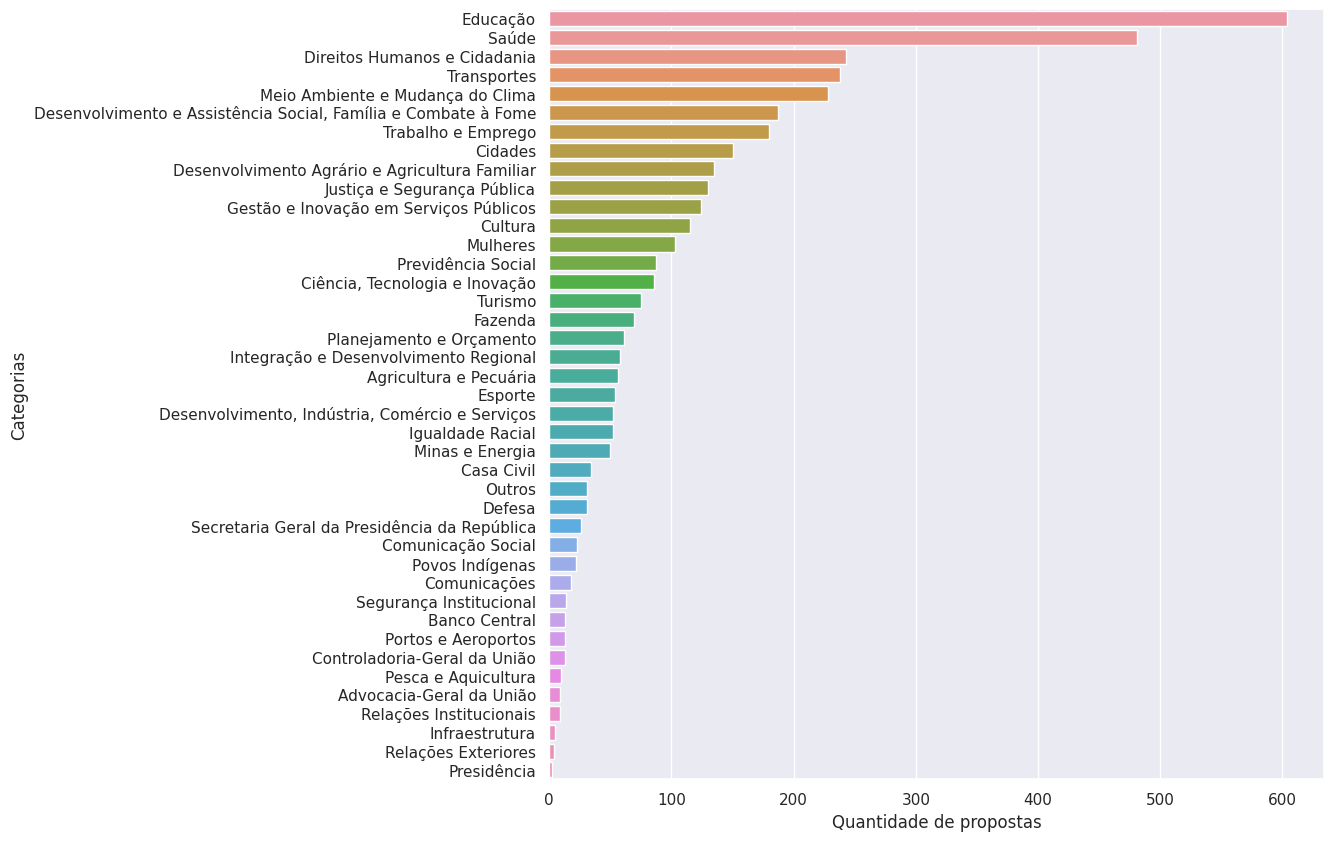

In [59]:
# Biblioteca pra visualização de gráficos
import seaborn as sns

sns.set(font_scale=1.0) # Definindo tamanho da fonte
counts = propostas.groupby(["Categoria"])["Categoria"].count()  # Contando valores por categoria
counts.sort_values(ascending=False, inplace=True) # Ordenando valores

ax = sns.barplot(y=counts.index, x=counts)  # Criando gráfico
ax.set(xlabel='Quantidade de propostas', ylabel='Categorias')
ax.figure.set_size_inches(10, 10)

A remoção das tags html  da coluna “body/pt-BR" são essenciais para o modelo de aprendizado de máquina. Com uso de um recurso da biblioteca BeautifulSoup, os títulos apagados por conter tags em html podem ser reescritos com os textos extraídos.

<h3 style="font-size:2rem;">CRIAÇÃO DO ARQUIVO COM AS ALTERAÇÕES E REMOÇÃO DO ANTERIOR</h3>

In [43]:
# Retorna o novo csv limpo
propostas.to_csv('data_extraction/propostas.csv', index=False)

# Remove o csv antigo 
os.remove('data_extraction/brasilparticipativo.presidencia.gov.br-open-data-proposals.csv')

Por último, cria-se um novo arquivo `csv` com as alterações feitas e o arquivo antigo é removido. O novo arquivo criado parte para a etapa de pré-processamento dos dados. 

<a id='pre-processing'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Pré-processamento Textual</h2>

Nesta etapa de pré-processamento, o objetivo é manipular as informações importantes para que o algoritmo de Machine Learning consiga entender e ser treinado. Algoritmos de Machine Learning não entendem dados textuais (não estruturados) e necessitam que eles sejam estruturados de forma que possam ser utilizados para treinamento. Para isso, os dados textuais serão, mais uma vez, processados para gerar uma representação vetorial. 

Além disso, nesta etapa, os dados serão trabalhados para otimização do modelo. Retirando palavras do texto que possuam baixo valor semântico para o processo de aprendizado de máquina. Essa limpeza é necessária para aumentar a precisão dos resultados do modelo treinado.

<h3 style="font-size:2rem;">DEFINIÇÕES INICIAIS</h3>

Nas definições iniciais, é declarado duas variáveis para expressões regulares e é instanciado o pipeline em português da biblioteca spaCy. Essas definições serão utilizadas na função de pré-processamento.

In [60]:
# Expressões regulares para remoção de links e tags HTMLs nos textos
REGX_URL = r"https?://[A-Za-z0-9./]+" # Regex for URLs
REGX_HTML = r"<[^<]+?>" # Regex for HTML tags

In [61]:
# Instanciando o pipeline em português do spaCy
# nlp = spacy.blank('pt') # Pipeline vazio para teste (apenas tokenização)
nlp = spacy.load('pt_core_news_sm')   # Pipeline pequeno (para eficiência)
# nlp = spacy.load('pt_core_news_lg')   # Pipeline grande (para precisão)

In [62]:
# Função para pré-processamento
def preprocessing(text):
  text = text.lower()

  text = re.sub(REGX_HTML, '', text)  # Removendo tags HTML
  text = re.sub(REGX_URL, '', text) # Revomendo URLs

  tokens = [t.text for t in nlp(text) if t not in STOP_WORDS and not t.is_punct]

  return ' '.join(tokens)

O spaCy é uma biblioteca gratuita e _open source_ para Processamento de Linguagem Natural avançado em Python. Foi especificamente projetada para uso em produção e para auxiliar na criação de aplicações que processam e "entendem" grandes volumes de texto. Ela pode ser usada para realizar a extração de informações, construir sistemas de compreensão de linguagem natural ou para pré-processar texto para modelos de Machine Learning e Deep Learning.

<h3 style="font-size:2rem">PRÉ-PROCESSAMENTO</h3>

<a id='training-model'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Treinamento do Modelo</h2>

<center><img alt="Work in Progress" src="https://cdn-icons-png.flaticon.com/512/5578/5578703.png" width=180 height=180></center>